## 確率分布のサンプリング

描画には[clgplot](https://github.com/masatoi/clgplot)を使っています。(gnuplotに依存してるので注意、Macでも動きました。)

In [1]:
; cl-waffeを読み込む
(load "../../cl-waffe.asd")
(ql:quickload `(:cl-waffe :clgplot) :silent t)

T

(:CL-WAFFE :CLGPLOT)

Unable to find framework CUDA


In [2]:
(defpackage :distribution-example
    (:use :cl :cl-waffe :clgplot :mgl-mat))

(in-package :distribution-example)

#<PACKAGE "DISTRIBUTION-EXAMPLE">

#<PACKAGE "DISTRIBUTION-EXAMPLE">

In [3]:
#+sbcl(declaim (sb-ext:muffle-conditions sb-kernel:redefinition-warning))

((#<SB-KERNEL::CONDITION-CLASSOID SB-KERNEL:REDEFINITION-WARNING>
  . MUFFLE-WARNING))

SB-INT:SIMPLE-STYLE-WARNING: DECLAIM where DECLARE was probably intended


In [4]:
; Utils

(defparameter *output-dir* nil)

(defmacro with-gnuplot (title &body body)
    `(let ((*output-dir* (format nil "./tmp/~a.png" ,title)))
          (locally ,@body)
          (jupyter:file *output-dir* :display t)))

(defun show-tensor (samples pdf &key (sample-n 30))
    "samples : サンプリングされた確率分布
     PDF     : 確率密度関数"
    (declare (type waffetensor samples)
             (type function pdf))
    (with-facets ((a* ((data samples) 'array)))
        (plot-histogram-with-pdf
         (coerce a* 'list)
         sample-n
         pdf
         :output *output-dir*)))

*OUTPUT-DIR*

WITH-GNUPLOT

SHOW-TENSOR

## 正規分布

(σは分散, μは平均) ここではσ=1.0, μ=0.0とする。

正規分布（標準分布、ガウス分布とも）は以下の確率密度関数で定義される確率分布。
$$
f(x)=\dfrac{1}{\sqrt{2\pi\sigma^2}}\exp(-\dfrac{(x-\mu)^ 2}{2\sigma^ 2})
$$

In [5]:
; single-floatで計算する
(defparameter pi-single-float (coerce pi 'single-float))

; 正規分布の確率密度関数
(defun standard-distribution (x &key (mean 0.0) (var 1.0))
    (declare (optimize (speed 3))
             (type single-float x mean var))
    (* (/ (sqrt (* 2 pi-single-float (expt var 2))))
       (exp (- (/ (expt (- x mean) 2) (* 2 (expt var 2)))))))

PI-SINGLE-FLOAT

STANDARD-DISTRIBUTION

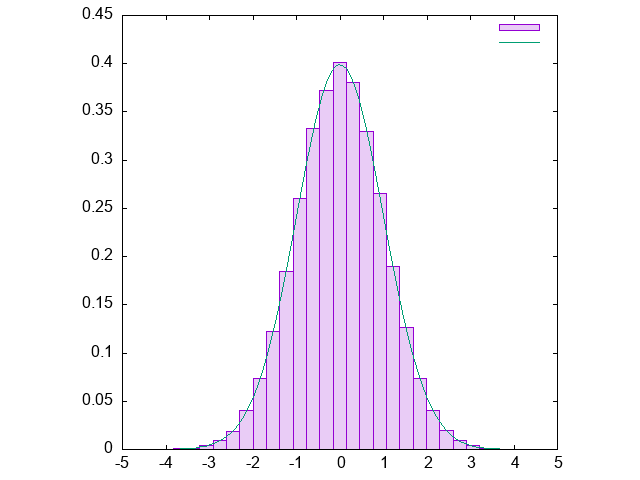

In [6]:
(with-gnuplot "randn"
    (show-tensor (!randn `(300000))
                 #'standard-distribution))

## ベータ分布

ベータ分布は、以下の確率密度関数で定義される確率分布

$$
f(x;\alpha,\beta) = \frac{x^{\alpha-1}(1-x)^{\beta-1}}{B(\alpha, \beta)} \quad \text{where} \quad x \in [0, 1]
$$

$$
B(\alpha, \beta) = \frac{\Gamma(\alpha)\Gamma(\beta)}{\Gamma(\alpha+\beta)}
$$

今回はα=2.0, β=1.0とする。

参考: 内部ではこの[近似アルゴリズム](https://dl.acm.org/doi/pdf/10.1145/359460.359482)を使っている。

ALPHA

BETA

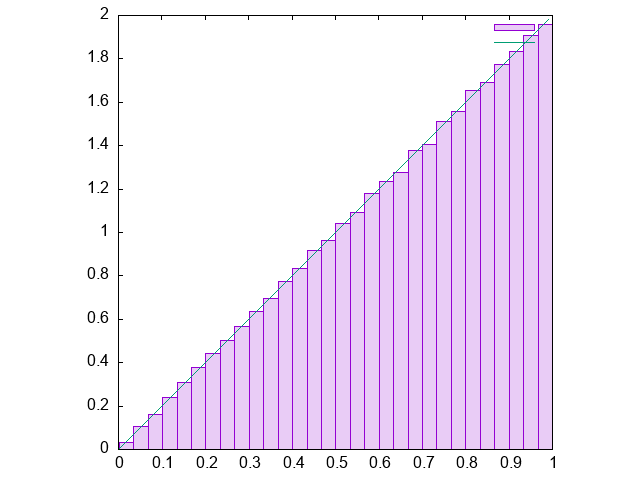

In [7]:
(defparameter alpha 2.0)
(defparameter beta 1.0)

(with-gnuplot "Beta"
    (show-tensor (!beta `(300000) alpha beta) #'(lambda (x) (* 2 x)))) ; とりあえず一次関数で、後で実装する・・・

### ガンマ分布

ガンマ分布は、以下の確率密度関数で定義される確率分布
$$
f(x; k, \theta) = \frac{1}{\Gamma(k)\theta^k}x^{k-1}e^{-\frac{x}{\theta}} \quad \text{for} \quad x > 0, \; k > 0, \; \theta > 0
$$

(自分で早いアルゴリズム実装しようと思ったけど、すごくめんどくさそうなので気が向いたらやる。現在はnumclの関数を呼び出して生成している。)

### カイ二条分布

カイ二乗分布は、ガンマ分布の特殊な場合として導出でき、確率密度関数は

$$
f(x; ν) = \frac{1}{\Gamma(\frac{ν}{2})2^{\frac{ν}{2}}}x^{\frac{ν}{2}-1}e^{-\frac{x}{2}}
$$

と定義される（内部でもこっちで計算してる。）

### ベルヌーイ分布

ベルヌーイ分布は確率質量関数が次のように定義でき:
$$
P(X=k) = p^k(1-p)^{1-k} \quad \text{for} \quad k \in \{0, 1\}
$$

単に確率pで1を、確率(1-p)で0を取る離散確率分布も表現できる。

### 一様乱数

xによらず全ての値を取る確率が一定 (6面サイコロとか)